# Onsala-1: Extracting Science from the data

In the previous notebook, we have fitted the spectra with our model. Now it is turn to do science with the obtained fitting. Our goal is to estimate the column density from this spectrum, which we can find by integrating the area under the spectral line. First let's see how good was our fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from glob import glob
import astropy.constants as con
import utils as utl
from scipy.optimize import minimize
import dynesty
from scipy import stats
import pickle
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal
import matplotlib.gridspec as gd

Loading the pickle file containing the data and the fitting...

In [4]:
post = pickle.load(open('Onsala1.pkl', 'rb'), encoding='latin1')

# Loading the data
velo, temp, temp_err = post['Data']['velocity_m/s'], post['Data']['temp_k'], post['Data']['temp_err']

# And the dictionary containing the samples
samps_dict = post['samples']
samps_keys = list(samps_dict.keys())

# Computing the median best fitted model
med_best_fit = np.zeros(14)

for i in range(len(samps_keys)):
    med_best_fit[i] = np.median(samps_dict[samps_keys[i]])
med_model = utl.model(velo, *med_best_fit)
## And residuals
resid = temp-med_model

(0.0, 90.0)

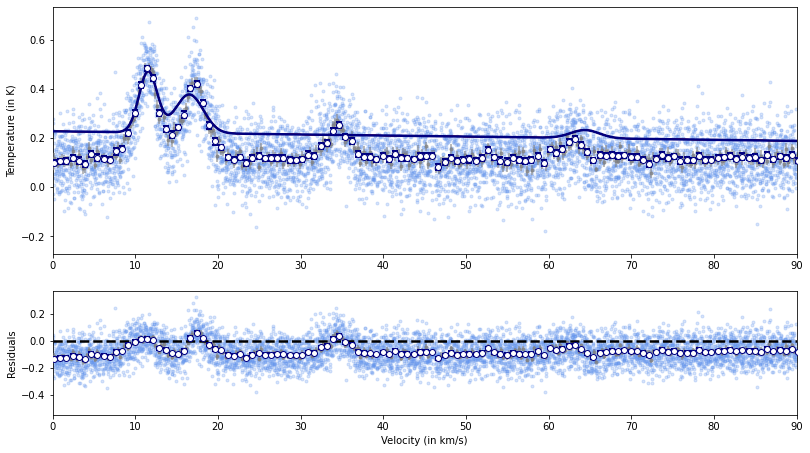

In [7]:
# For binning
## Top panel
vbin1, tbin1, tebin1, _ = utl.lcbin(velo, temp, binwidth=250)
vbin, tbin, tebin, _ = utl.lcbin(velo, temp, binwidth=750)
## Bottom panel
_, re_bin1, ree_bin1, _ = utl.lcbin(velo, resid, binwidth=250)
_, re_bin, ree_bin, _ = utl.lcbin(velo, resid, binwidth=750)

# Visualising the results
fig = plt.figure(figsize=(16/1.2,9/1.2))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(velo/1e3, temp, fmt='.', alpha=0.25, c='cornflowerblue')
ax1.errorbar(vbin/1e3, tbin, yerr=tebin, fmt='o', c='navy', elinewidth=2, capthick=2, capsize=3, mfc='white', zorder=150)
ax1.errorbar(vbin1/1e3, tbin1, yerr=tebin1, fmt='.', c='gray', alpha=0.7, zorder=50)
ax1.plot(velo/1e3, med_model, c='navy', zorder=100, lw=2.5)
for i in range(50):
    rand_model_param = np.zeros(14)
    for j in range(len(samps_keys)):
        rand_model_param[j] = np.random.choice(samps_dict[samps_keys[j]], replace=False)
    random_model = utl.model(velo, *rand_model_param)
    ax1.plot(velo/1e3, random_model, c='orangered', zorder=75, lw=1, alpha=0.3)
ax1.set_ylabel('Temperature (in K)')
ax1.set_xlim([0,90])

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(velo/1e3, resid, fmt='.', alpha=0.25, c='cornflowerblue')
ax2.axhline(y=0.0, c='black', ls='--', zorder=100, lw=2.5)
ax2.errorbar(vbin/1e3, re_bin, yerr=ree_bin, fmt='o', c='navy', elinewidth=2, capthick=2, capsize=3, mfc='white', zorder=150)
ax2.errorbar(vbin1/1e3, re_bin1, yerr=ree_bin1, fmt='.', c='gray', alpha=0.7, zorder=50)
ax2.set_ylabel('Residuals')
ax2.set_xlabel('Velocity (in km/s)')
ax2.set_xlim([0,90])
#ax2.set_ylim([-200,200])